<a href="https://colab.research.google.com/github/henterm/linked-blog-starter-md/blob/main/lab02_part_1_main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [3]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

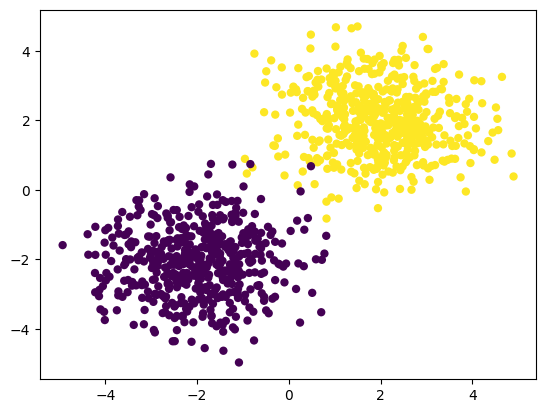

In [2]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

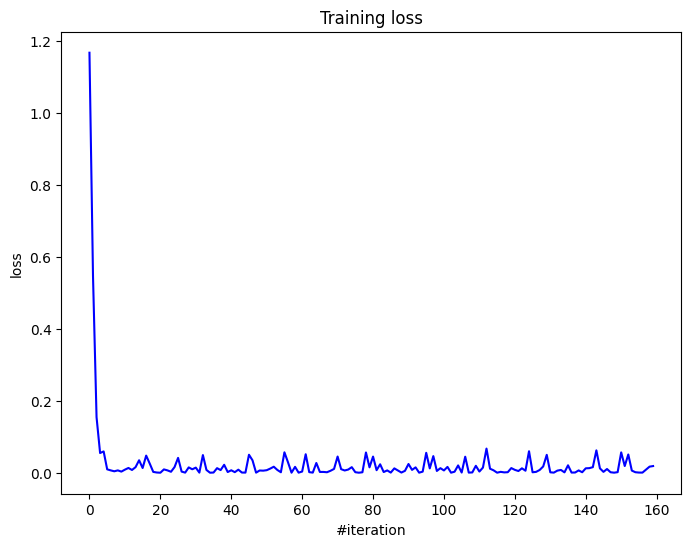

Current loss: 0.018620


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [2]:
import numpy as np
import struct
from array import array


def read_images_labels(images_filepath, labels_filepath):
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img

    return images, labels


train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")


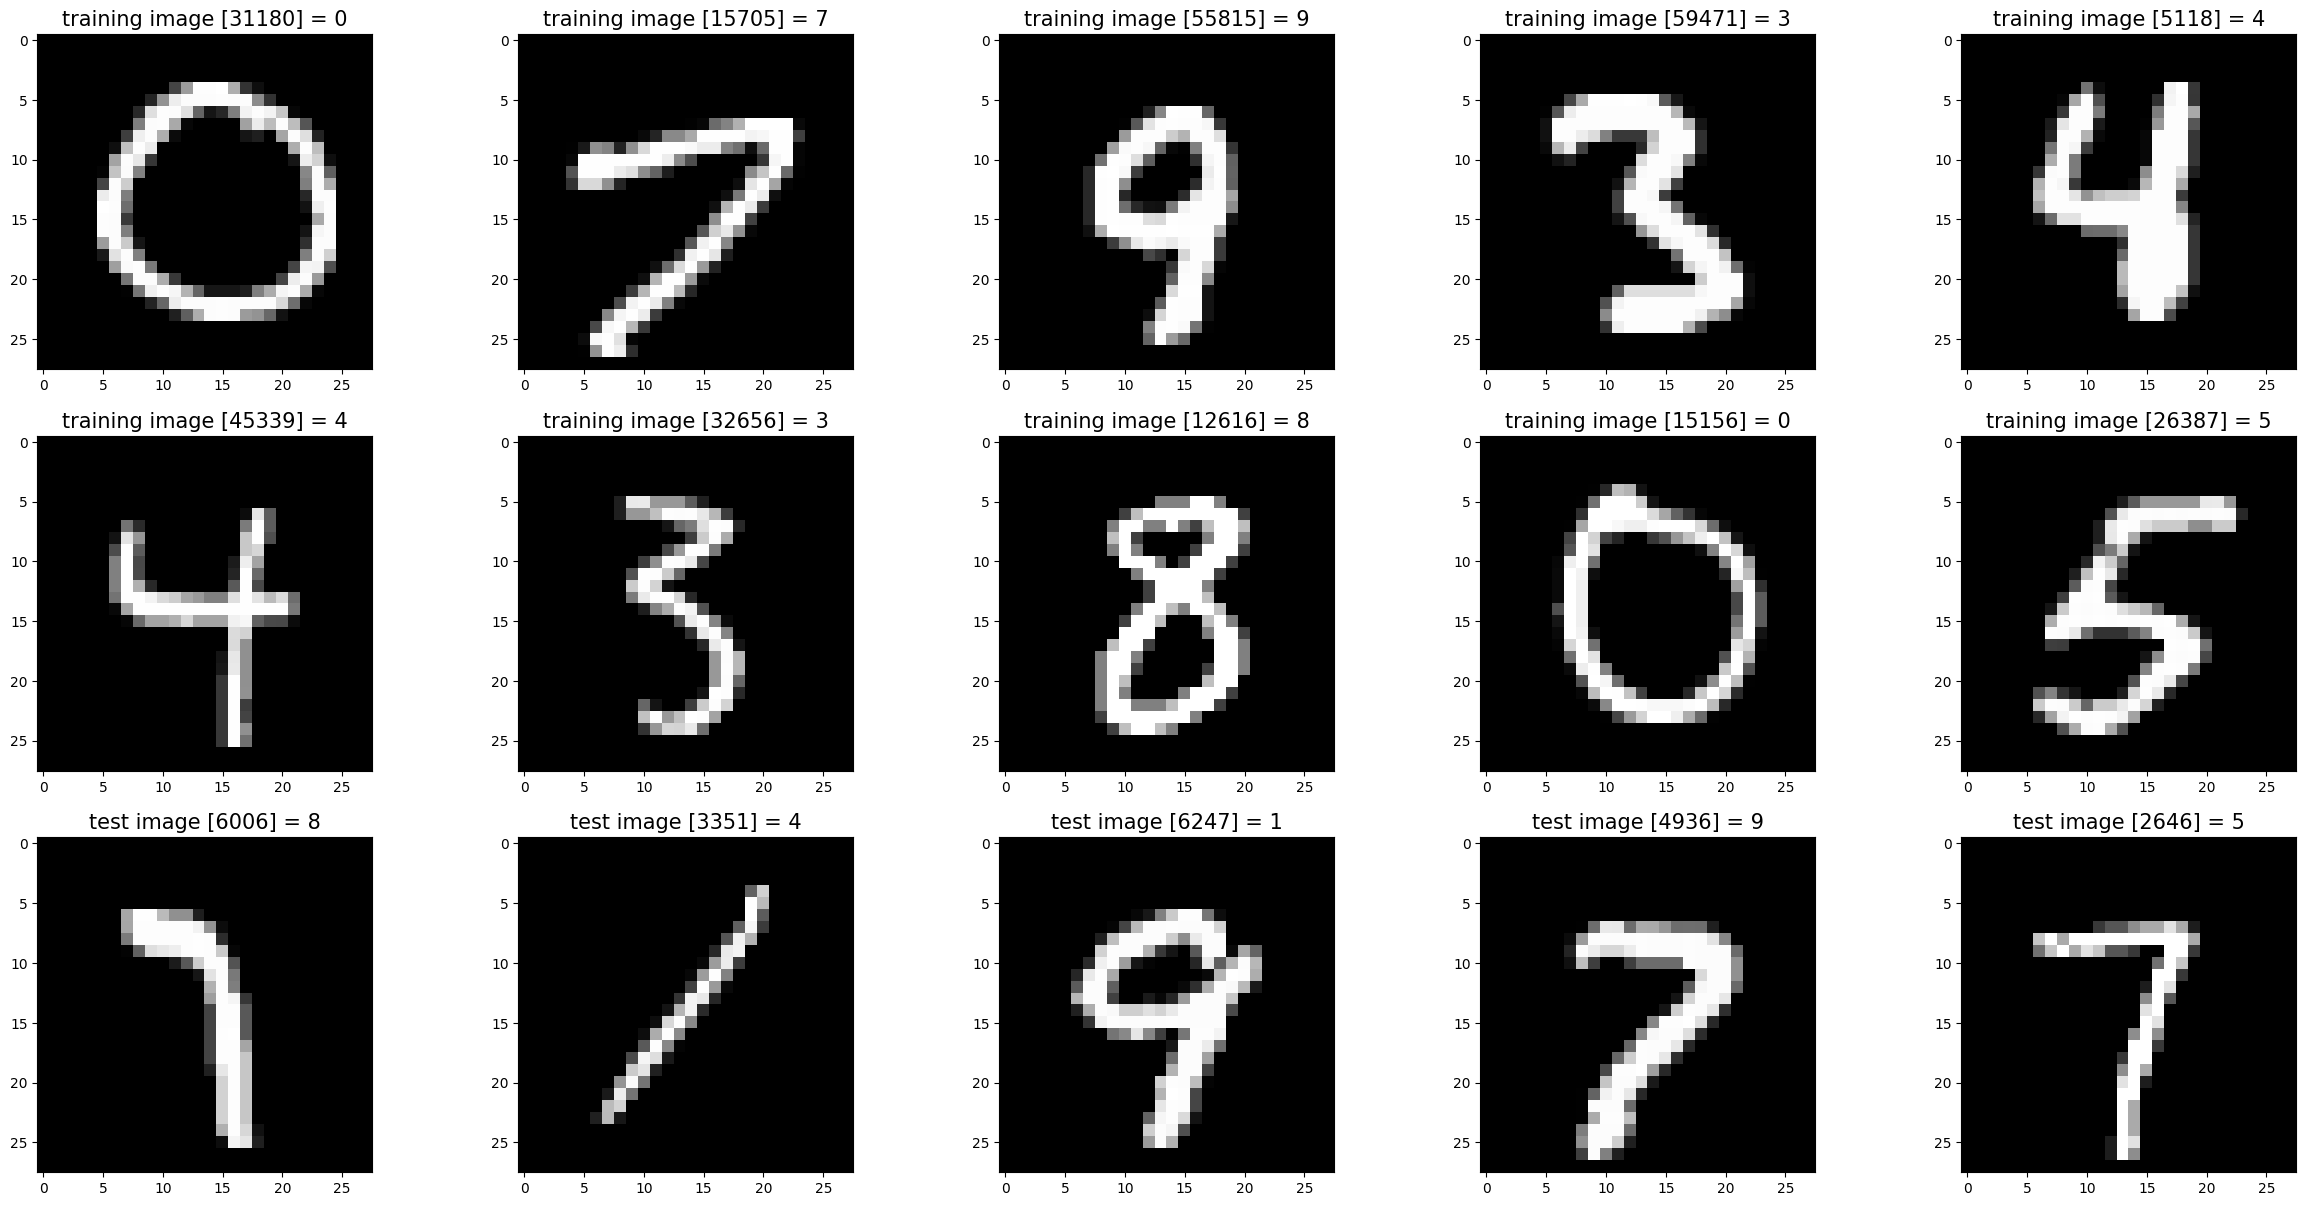

In [3]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(train_images[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(train_labels[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(test_images[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(train_labels[r]))

show_images(images_2_show, titles_2_show)




One-hot encode the labels first.

In [4]:
import numpy as np

def one_hot_encode(labels, num_classes=10):
    """
    Преобразует список меток в формат one-hot encoding.

    :param labels: список или массив меток.
    :param num_classes: общее количество классов (по умолчанию 10 для MNIST).
    :return: массив размера (len(labels), num_classes).
    """
    encoded = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        encoded[i, label] = 1
    return encoded

# One-hot encode train and test labels
train_labels_one_hot = one_hot_encode(train_labels)
test_labels_one_hot = one_hot_encode(test_labels)

print("Пример оригинальной метки:", train_labels[0])
print("One-hot encoded метка:", train_labels_one_hot[0])


Пример оригинальной метки: 5
One-hot encoded метка: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Загрузка и нормализация данных MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.49MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
class SimpleNet(nn.Module):
    def __init__(self, activation_fn):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.bn1 = nn.BatchNorm1d(256)  # BatchNormalization
        self.act1 = activation_fn
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)  # BatchNormalization
        self.act2 = activation_fn
        self.fc3 = nn.Linear(128, 10)  # Выходной слой

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.bn1(self.fc1(x))
        x = self.act1(x)
        x = self.bn2(self.fc2(x))
        x = self.act2(x)
        x = self.fc3(x)
        return x


In [9]:
# Определим функции активации
activations = {
    'ReLU': nn.ReLU(),
    'ELU': nn.ELU(),
    'LeakyReLU': nn.LeakyReLU(),
    'SoftPlus': nn.Softplus()
}

# Список оптимизаторов для сравнения
optimizers = {
    'Momentum SGD': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    'Adam': lambda params: optim.Adam(params, lr=0.001)
}


In [10]:
def train_model(model, optimizer, trainloader, criterion, epochs=5):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}')
    return losses


Training with ReLU...
Epoch [1/10], Loss: 0.2072
Epoch [2/10], Loss: 0.0842
Epoch [3/10], Loss: 0.0610
Epoch [4/10], Loss: 0.0457
Epoch [5/10], Loss: 0.0373
Epoch [6/10], Loss: 0.0288
Epoch [7/10], Loss: 0.0268
Epoch [8/10], Loss: 0.0219
Epoch [9/10], Loss: 0.0197
Epoch [10/10], Loss: 0.0181
Training with ELU...
Epoch [1/10], Loss: 0.2577
Epoch [2/10], Loss: 0.1260
Epoch [3/10], Loss: 0.0927
Epoch [4/10], Loss: 0.0749
Epoch [5/10], Loss: 0.0609
Epoch [6/10], Loss: 0.0527
Epoch [7/10], Loss: 0.0461
Epoch [8/10], Loss: 0.0388
Epoch [9/10], Loss: 0.0373
Epoch [10/10], Loss: 0.0300
Training with LeakyReLU...
Epoch [1/10], Loss: 0.2064
Epoch [2/10], Loss: 0.0860
Epoch [3/10], Loss: 0.0599
Epoch [4/10], Loss: 0.0468
Epoch [5/10], Loss: 0.0363
Epoch [6/10], Loss: 0.0319
Epoch [7/10], Loss: 0.0284
Epoch [8/10], Loss: 0.0219
Epoch [9/10], Loss: 0.0198
Epoch [10/10], Loss: 0.0180
Training with SoftPlus...
Epoch [1/10], Loss: 0.2901
Epoch [2/10], Loss: 0.1344
Epoch [3/10], Loss: 0.1032
Epoch [4/1

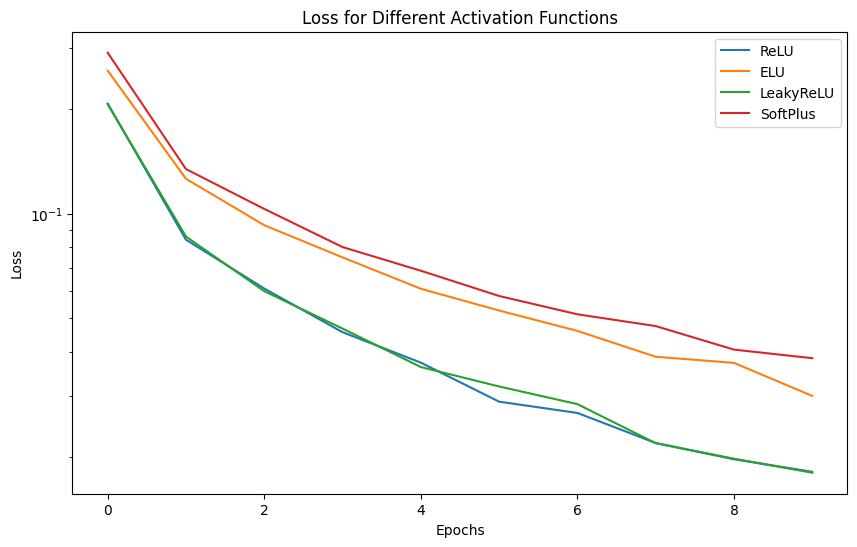

In [11]:
criterion = nn.CrossEntropyLoss()
epochs = 10

results = {}

# Сравнение функций активации
for act_name, activation_fn in activations.items():
    print(f"Training with {act_name}...")
    model = SimpleNet(activation_fn)
    optimizer = optimizers['Adam'](model.parameters())
    losses = train_model(model, optimizer, trainloader, criterion, epochs)
    results[act_name] = losses

# Построение графиков для функций активации
plt.figure(figsize=(10, 6))
for act_name, loss in results.items():
    plt.plot(range(epochs), loss, label=act_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss for Different Activation Functions')
plt.legend()
plt.show()


Training with Momentum SGD...
Epoch [1/10], Loss: 0.2163
Epoch [2/10], Loss: 0.0880
Epoch [3/10], Loss: 0.0611
Epoch [4/10], Loss: 0.0438
Epoch [5/10], Loss: 0.0341
Epoch [6/10], Loss: 0.0283
Epoch [7/10], Loss: 0.0213
Epoch [8/10], Loss: 0.0180
Epoch [9/10], Loss: 0.0165
Epoch [10/10], Loss: 0.0127
Training with Adam...
Epoch [1/10], Loss: 0.2057
Epoch [2/10], Loss: 0.0849
Epoch [3/10], Loss: 0.0591
Epoch [4/10], Loss: 0.0455
Epoch [5/10], Loss: 0.0347
Epoch [6/10], Loss: 0.0317
Epoch [7/10], Loss: 0.0251
Epoch [8/10], Loss: 0.0239
Epoch [9/10], Loss: 0.0190
Epoch [10/10], Loss: 0.0193


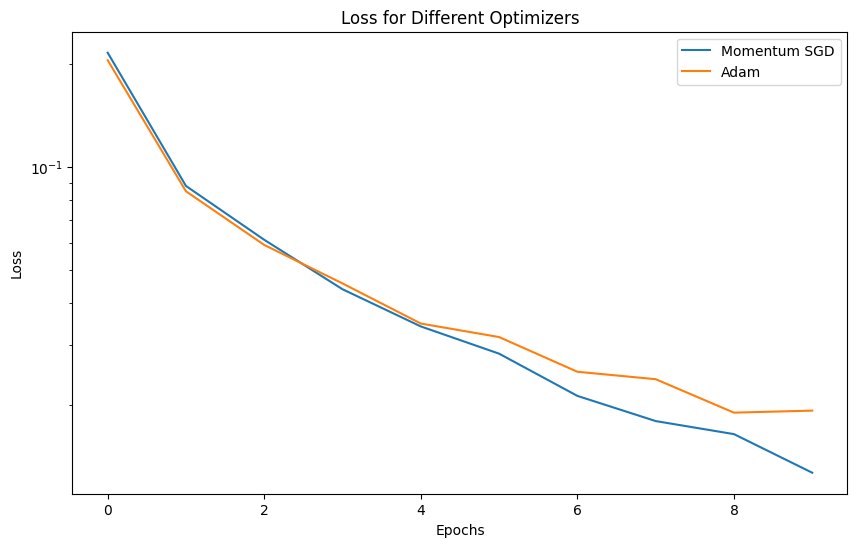

In [12]:
# Сравнение оптимизаторов Adam и Momentum SGD
opt_results = {}

for opt_name, opt_fn in optimizers.items():
    print(f"Training with {opt_name}...")
    model = SimpleNet(nn.ReLU())  # Используем ReLU для обоих
    optimizer = opt_fn(model.parameters())
    losses = train_model(model, optimizer, trainloader, criterion, epochs)
    opt_results[opt_name] = losses

# Построение графиков для оптимизаторов
plt.figure(figsize=(10, 6))
for opt_name, loss in opt_results.items():
    plt.plot(range(epochs), loss, label=opt_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss for Different Optimizers')
plt.legend()
plt.show()


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

1. Выводы по функциям активации:


*   ReLU: Быстрая и простая активация, но может страдать от проблемы "мертвых нейронов" (значения, которые всегда 0).
*   ELU: Плавнее, чем ReLU, и справляется с "мертвыми нейронами", но вычислительно дороже.
*   LeakyReLU: Решает проблему "мертвых нейронов", позволяя небольшой наклон в отрицательной области, при этом всё ещё быстрая.
*   SoftPlus: Гладкая версия ReLU, но более вычислительно сложная.

2. BatchNormalization


*   BatchNormalization стабилизирует и ускоряет обучение, помогая лучше усваивать глубокие нейронные сети. Введение нормализации каналов уменьшает переобучение.

3. Сравнение оптимизаторов



*   Adam: Быстро сходится и не требует тщательного подбора параметров.
*   Momentum SGD: Традиционный оптимизатор, работает лучше на более простых задачах, но требует настройки параметров.







**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Преобразование данных с аугментацией
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка данных с аугментацией
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Определение модели с Dropout
class CoolNet(nn.Module):
    def __init__(self):
        super(CoolNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)  # Dropout для регуляризации
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)  # Еще один Dropout
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.bn1(self.fc1(x))
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.bn2(self.fc2(x))
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Функция для тренировки модели
def train(model, trainloader, criterion, optimizer, epochs=10, lr_scheduler=None):
    model.train()  # Включаем режим тренировки
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if lr_scheduler:
            lr_scheduler.step()  # Обновляем learning rate по расписанию

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    print('Training finished')

# Функция для оценки модели
def evaluate(model, testloader):
    model.eval()  # Включаем режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy


In [14]:
# Инициализация модели
model = CoolNet()

# Кросс-энтропийная ошибка
criterion = nn.CrossEntropyLoss()

# Оптимизатор Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Снижение learning rate на 0.1 каждые 5 эпох
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Обучение модели с Dropout, аугментацией и динамическим learning rate
train(model, trainloader, criterion, optimizer, epochs=15, lr_scheduler=lr_scheduler)

# Оценка модели на тестовых данных
accuracy = evaluate(model, testloader)


Epoch [1/15], Loss: 0.3619
Epoch [2/15], Loss: 0.2966
Epoch [3/15], Loss: 0.3521
Epoch [4/15], Loss: 0.3912
Epoch [5/15], Loss: 0.2837
Epoch [6/15], Loss: 0.1783
Epoch [7/15], Loss: 0.4791
Epoch [8/15], Loss: 0.1965
Epoch [9/15], Loss: 0.4390
Epoch [10/15], Loss: 0.1624
Epoch [11/15], Loss: 0.2507
Epoch [12/15], Loss: 0.1039
Epoch [13/15], Loss: 0.1455
Epoch [14/15], Loss: 0.3285
Epoch [15/15], Loss: 0.0785
Training finished
Accuracy on test set: 98.26%


Print here your accuracy on test set. It should be around 90%.

**Выводы:**


*   Data Augmentation: Использование аугментации данных, таких как случайные вращения и сдвиги, позволяет модели лучше обобщать данные и избегать переобучения.
*   Dropout: Отлично помогает при работе с глубокими сетями и снижает переобучение, особенно на финальных слоях.
*   Learning Rate Decay: Снижение скорости обучения помогает более плавно достичь глобального минимума ошибки на поздних этапах обучения.




### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Преобразование данных с аугментацией для тренировки
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка данных
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Определение модели с Dropout и BatchNormalization
class PyTorchNet(nn.Module):
    def __init__(self):
        super(PyTorchNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Инициализация модели
model = PyTorchNet()

# Кросс-энтропийная функция потерь
criterion = nn.CrossEntropyLoss()

# Оптимизатор Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
def train_pytorch_model(model, trainloader, criterion, optimizer, epochs=15):
    model.train()  # Включаем режим тренировки
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    print('Training finished')

# Функция для оценки точности модели
def evaluate_pytorch_model(model, testloader):
    model.eval()  # Включаем режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

# Обучение и оценка модели
train_pytorch_model(model, trainloader, criterion, optimizer)
accuracy = evaluate_pytorch_model(model, testloader)


Epoch [1/15], Loss: 0.3054
Epoch [2/15], Loss: 0.3754
Epoch [3/15], Loss: 0.5230
Epoch [4/15], Loss: 0.1952
Epoch [5/15], Loss: 0.3634
Epoch [6/15], Loss: 0.8339
Epoch [7/15], Loss: 0.1308
Epoch [8/15], Loss: 0.1841
Epoch [9/15], Loss: 0.5477
Epoch [10/15], Loss: 0.2186
Epoch [11/15], Loss: 0.1106
Epoch [12/15], Loss: 0.2611
Epoch [13/15], Loss: 0.1788
Epoch [14/15], Loss: 0.3984
Epoch [15/15], Loss: 0.3742
Training finished
Accuracy on test set: 98.41%
